ref : https://github.com/lbarazza/VPG-PyTorch/blob/master/vpg.py

In [65]:
from enum import Enum
from typing import List
from collections import deque
from copy import copy
import random
import matplotlib.pyplot as plt

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np

In [7]:
class JankenHand(Enum):
    GUU = 0
    CHOKI = 1
    PAA = 2

    @staticmethod
    def idx2hand(idx: int):
        for hand in JankenHand:
            if idx == hand.value:
                return hand
        raise ValueError(f'not supported hand index {idx}')

In [12]:
class JankenResult(Enum):
    YOUR_WIN = 1
    DRAW = 0
    YOUR_LOSE = -1

In [47]:
class Oponent:
    """グー -> チョキ -> パーを繰り返す相手"""

    def __init__(self):
        self._n = 0
    
    def hand(self) -> JankenHand:
        hand = JankenHand.idx2hand(self._n%3)
        self._n += 1
        return hand

    def reset(self) -> None:
        self._n = 0

In [9]:
oponent = Oponent()

In [10]:
for i in range(7):
    print(oponent.hand())

JankenHand.GUU
JankenHand.CHOKI
JankenHand.PAA
JankenHand.GUU
JankenHand.CHOKI
JankenHand.PAA
JankenHand.GUU


In [78]:
class JankenEnv:

    STATE_DIM = 6

    def __init__(self):
        self._oponent = Oponent()
        self._state = self.reset()

    def step(self, action: JankenHand):
        oponent_hand = self._oponent.hand()
        self._state.append(oponent_hand)
        if (action == JankenHand.GUU and oponent_hand == JankenHand.CHOKI) or \
            (action == JankenHand.CHOKI and oponent_hand == JankenHand.PAA) or \
            (action == JankenHand.PAA and oponent_hand == JankenHand.GUU):
            result = JankenResult.YOUR_WIN
        elif (action == JankenHand.GUU and oponent_hand == JankenHand.PAA) or \
            (action == JankenHand.CHOKI and oponent_hand == JankenHand.GUU) or \
            (action == JankenHand.PAA and oponent_hand == JankenHand.CHOKI):
            result = JankenResult.YOUR_LOSE
        else:
            result = JankenResult.DRAW
        reward = result.value - 0.1*len(self._results)
        self._results.append(result)
        done = False
        if len(self._results) >= 3:
            # 3回連続で勝利したらdone
            done = all([res==JankenResult.YOUR_WIN for res in self._results[-3:]])
        next_state = copy(self._state)
        return next_state, reward, done

    def reset(self) -> deque:
        self._state = deque([JankenHand.GUU]*JankenEnv.STATE_DIM, maxlen=JankenEnv.STATE_DIM)
        self._oponent.reset()
        self._results = []
        return self._state

    @property
    def results(self) -> List[JankenResult]:
        return self._results

In [79]:
janken_env = JankenEnv()

In [80]:
random.randint(0, 2)

1

In [81]:
janken_env.reset()
for i in range(50):
    next_state, reward, done = janken_env.step(action=JankenHand.idx2hand(random.randint(0, 2)))
    print(f'{next_state} : {reward} : {done}')

deque([<JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>], maxlen=6) : -1.0 : False
deque([<JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.CHOKI: 1>], maxlen=6) : -1.1 : False
deque([<JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.CHOKI: 1>, <JankenHand.PAA: 2>], maxlen=6) : 0.8 : False
deque([<JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.CHOKI: 1>, <JankenHand.PAA: 2>, <JankenHand.GUU: 0>], maxlen=6) : 0.7 : False
deque([<JankenHand.GUU: 0>, <JankenHand.GUU: 0>, <JankenHand.CHOKI: 1>, <JankenHand.PAA: 2>, <JankenHand.GUU: 0>, <JankenHand.CHOKI: 1>], maxlen=6) : -0.4 : False
deque([<JankenHand.GUU: 0>, <JankenHand.CHOKI: 1>, <JankenHand.PAA: 2>, <JankenHand.GUU: 0>, <JankenHand.CHOKI: 1>, <JankenHand.PAA: 2>], maxlen=6) : 0.5 : False
deque([<JankenHand.CHOKI: 1>, <Jank

In [82]:
class PolicyNet(nn.Module):
    def __init__(self, nS, nH, nA): # nS: state space size, nH: n. of neurons in hidden layer, nA: size action space
        super(PolicyNet, self).__init__()
        self.h = nn.Linear(nS, nH)
        self.out = nn.Linear(nH, nA)

    # define forward pass with one hidden layer with ReLU activation and sofmax after output layer
    def forward(self, x):
        x = F.relu(self.h(x))
        x = F.softmax(self.out(x), dim=1)
        return x

In [83]:
OBSERVATION_SPACE_DIM = 6
HIDDEN_DIM =20
ACTION_DIM = 3

In [94]:
policy_net = PolicyNet(OBSERVATION_SPACE_DIM, HIDDEN_DIM, ACTION_DIM)

In [95]:
optimizer = torch.optim.Adam(policy_net.parameters())

In [96]:
gamma = 0.99
n_episode = 1
returns = deque(maxlen=100)

In [97]:
N_EPISODES = 200

In [98]:
results_episodes = []

for episode in range(N_EPISODES):
    rewards = []
    actions = []
    states  = []
    # reset environment
    state = janken_env.reset()
    state = [s.value for s in state]
    while True:

        # calculate probabilities of taking each action
        probs = policy_net(torch.tensor(state).unsqueeze(0).float())
        # sample an action from that set of probs
        sampler = Categorical(probs)
        action = sampler.sample()

        # use that action in the environment
        new_state, reward, done = janken_env.step(JankenHand.idx2hand(action.item()))
        new_state = [s.value for s in new_state]
        # store state, action and reward
        states.append(state)
        actions.append(action)
        rewards.append(reward)

        state = new_state
        if done:
            break

    # preprocess rewards
    rewards = np.array(rewards)
    # calculate rewards to go for less variance
    R = torch.tensor([np.sum(rewards[i:]*(gamma**np.array(range(i, len(rewards))))) for i in range(len(rewards))])
    # or uncomment following line for normal rewards
    #R = torch.sum(torch.tensor(rewards))

    # preprocess states and actions
    states = torch.tensor(states).float()
    actions = torch.tensor(actions)

    # calculate gradient
    probs = policy_net(states)
    sampler = Categorical(probs)
    log_probs = -sampler.log_prob(actions)   # "-" because it was built to work with gradient descent, but we are using gradient ascent
    pseudo_loss = torch.sum(log_probs * R) # loss that when differentiated with autograd gives the gradient of J(θ)
    # update policy weights
    optimizer.zero_grad()
    pseudo_loss.backward()
    optimizer.step()

    # calculate average return and print it out
    returns.append(np.sum(rewards))
    print("Episode: {:6d}\tAvg. Return: {:6.2f}".format(n_episode, np.mean(returns)))
    n_episode += 1

    results_episodes.append(copy(janken_env.results))

Episode:      1	Avg. Return: -457.00
Episode:      2	Avg. Return: -266.65
Episode:      3	Avg. Return: -179.47
Episode:      4	Avg. Return: -142.72
Episode:      5	Avg. Return: -115.40
Episode:      6	Avg. Return: -95.85
Episode:      7	Avg. Return: -85.30
Episode:      8	Avg. Return: -74.27
Episode:      9	Avg. Return: -65.80
Episode:     10	Avg. Return: -77.32
Episode:     11	Avg. Return: -70.94
Episode:     12	Avg. Return: -65.15
Episode:     13	Avg. Return: -62.61
Episode:     14	Avg. Return: -89.74
Episode:     15	Avg. Return: -85.09
Episode:     16	Avg. Return: -91.17
Episode:     17	Avg. Return: -88.74
Episode:     18	Avg. Return: -83.76
Episode:     19	Avg. Return: -79.62
Episode:     20	Avg. Return: -75.72
Episode:     21	Avg. Return: -72.22
Episode:     22	Avg. Return: -71.34
Episode:     23	Avg. Return: -87.87
Episode:     24	Avg. Return: -84.17
Episode:     25	Avg. Return: -97.44
Episode:     26	Avg. Return: -98.48
Episode:     27	Avg. Return: -94.86
Episode:     28	Avg. Re

In [99]:
# エピソード
results_episodes[0]

[<JankenResult.YOUR_LOSE: -1>,
 <JankenResult.YOUR_LOSE: -1>,
 <JankenResult.DRAW: 0>,
 <JankenResult.YOUR_WIN: 1>,
 <JankenResult.YOUR_LOSE: -1>,
 <JankenResult.YOUR_WIN: 1>,
 <JankenResult.DRAW: 0>,
 <JankenResult.YOUR_LOSE: -1>,
 <JankenResult.YOUR_LOSE: -1>,
 <JankenResult.YOUR_LOSE: -1>,
 <JankenResult.YOUR_WIN: 1>,
 <JankenResult.DRAW: 0>,
 <JankenResult.YOUR_WIN: 1>,
 <JankenResult.YOUR_LOSE: -1>,
 <JankenResult.YOUR_WIN: 1>,
 <JankenResult.YOUR_WIN: 1>,
 <JankenResult.DRAW: 0>,
 <JankenResult.DRAW: 0>,
 <JankenResult.YOUR_LOSE: -1>,
 <JankenResult.YOUR_LOSE: -1>,
 <JankenResult.DRAW: 0>,
 <JankenResult.DRAW: 0>,
 <JankenResult.DRAW: 0>,
 <JankenResult.YOUR_WIN: 1>,
 <JankenResult.YOUR_LOSE: -1>,
 <JankenResult.YOUR_LOSE: -1>,
 <JankenResult.DRAW: 0>,
 <JankenResult.YOUR_WIN: 1>,
 <JankenResult.YOUR_WIN: 1>,
 <JankenResult.DRAW: 0>,
 <JankenResult.DRAW: 0>,
 <JankenResult.YOUR_WIN: 1>,
 <JankenResult.YOUR_LOSE: -1>,
 <JankenResult.YOUR_LOSE: -1>,
 <JankenResult.YOUR_WIN: 1>,
 <J

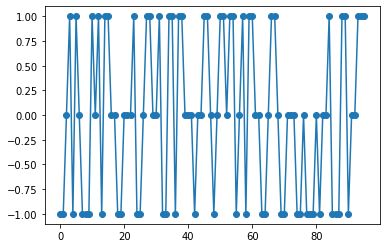

In [100]:
plt.plot([r.value for r in results_episodes[0]], marker='o')

In [104]:
# 200エピソード
results_episodes[-1]

[<JankenResult.DRAW: 0>,
 <JankenResult.YOUR_LOSE: -1>,
 <JankenResult.YOUR_LOSE: -1>,
 <JankenResult.YOUR_WIN: 1>,
 <JankenResult.YOUR_WIN: 1>,
 <JankenResult.YOUR_LOSE: -1>,
 <JankenResult.YOUR_WIN: 1>,
 <JankenResult.DRAW: 0>,
 <JankenResult.DRAW: 0>,
 <JankenResult.YOUR_WIN: 1>,
 <JankenResult.YOUR_WIN: 1>,
 <JankenResult.YOUR_WIN: 1>]

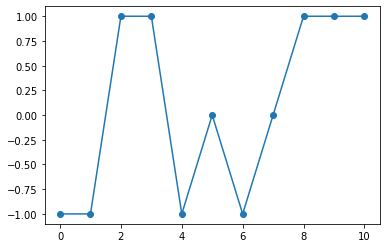

In [101]:
plt.plot([r.value for r in results_episodes[-2]], marker='o')

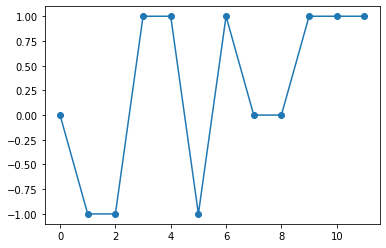

In [102]:
plt.plot([r.value for r in results_episodes[-1]], marker='o')

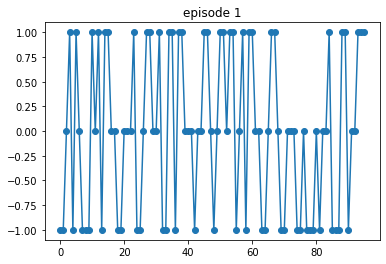

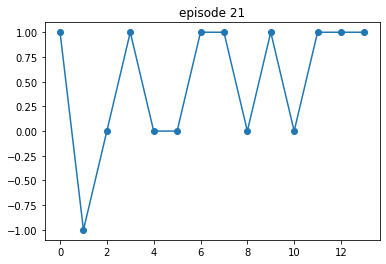

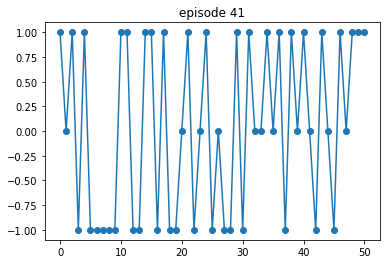

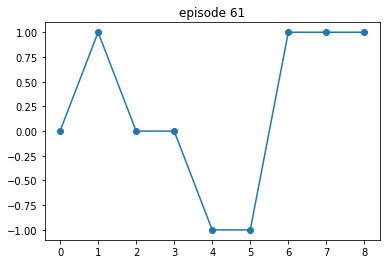

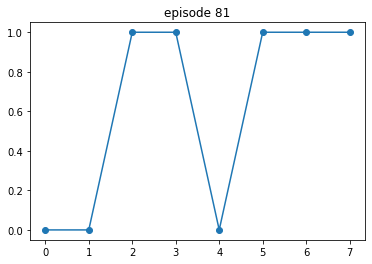

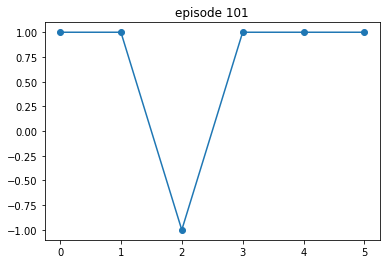

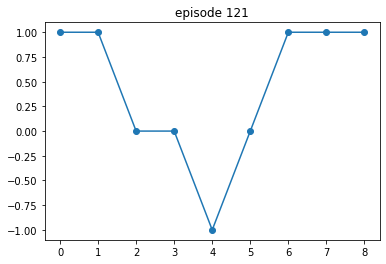

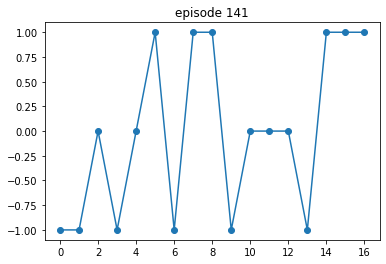

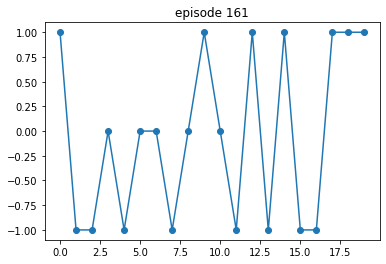

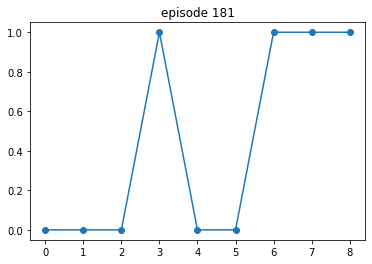

In [103]:
for episode in range(N_EPISODES):
    if episode % 20 == 0:
        plt.plot([r.value for r in results_episodes[episode]], marker='o')
        plt.title(f'episode {episode+1}')
        plt.show()